In [6]:
library(dslabs)
library(dplyr)
data(heights)
heights[777,]
which.min(heights$height)
median(c(heights$height))
filter(heights,sex=="Female",height>78)



,sex,height
,<fct>,<dbl>
777,Female,61


[1] 1032

[1] 68.5

sex,height
<fct>,<dbl>
Female,78.74016
Female,79.00000


In [7]:
str(heights)

'data.frame':	1050 obs. of  2 variables:
 $ sex   : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 1 1 1 1 2 ...
 $ height: num  75 70 68 74 61 65 66 62 66 67 ...


# outcome=what we want to predict,Y

# Features=info used to predict outcome,X

# outcomes can be categorial or continuous

# categorial <- any of k classes,Classification

# Decision Rule<- The K variable that is chosen

# continuous<- prediction

# Error<- Diffrence between True value and prediction y - ^Y 



## Evaluation Metrics

- make two sets(training and testing)

- training-used to devolp algorithm

- test-pretend we dont know the outcome

- Function createDataPartition()-helps break up data to build sets, parameters(time=number of randon samples,p=proportion of data represented by index,list=returned as a list or not)

- overall accuracy-proportion of cases that were correct in test set



In [13]:

library(tidyverse)
library(caret)
library(dslabs)
data(heights)

In [14]:
# define the outcome and predictors
y <- heights$sex
x <- heights$height

In [15]:
# generate training and test sets
set.seed(2007)
test_index <- createDataPartition(y, times = 1, p = 0.5, list = FALSE)
test_set <- heights[test_index, ]
train_set <- heights[-test_index, ]

In [18]:
# guess the outcome
y_hat <- sample(c("Male", "Female"), length(test_index), replace = TRUE) %>% 
  factor(levels = levels(test_set$sex))

In [19]:
# compute accuracy
mean(y_hat == test_set$sex)

[1] 0.5104762

In [20]:
# compare heights in males and females in our data set
heights %>% group_by(sex) %>% summarize(mean(height), sd(height))

sex,mean(height),sd(height)
<fct>,<dbl>,<dbl>
Female,64.93942,3.760656
Male,69.31475,3.611024


In [10]:
# now try predicting "male" if the height is within 2 SD of the average male
y_hat <- ifelse(x > 62, "Male", "Female") %>% factor(levels = levels(test_set$sex))
mean(y == y_hat)

[1] 0.7933333

In [21]:
# examine the accuracy of 10 cutoffs
cutoff <- seq(61, 70)
accuracy <- map_dbl(cutoff, function(x){
  y_hat <- ifelse(train_set$height > x, "Male", "Female") %>% 
    factor(levels = levels(test_set$sex))
    mean(y_hat == train_set$sex)
})


[1] 0.8495238

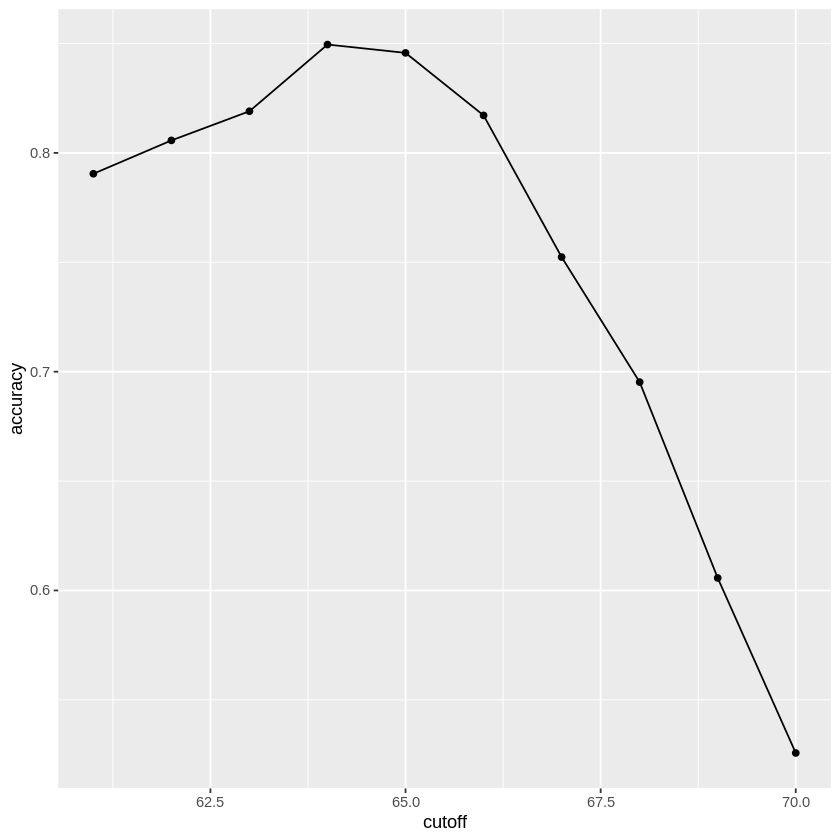

In [22]:
data.frame(cutoff, accuracy) %>% 
  ggplot(aes(cutoff, accuracy)) + 
  geom_point() + 
  geom_line() 
max(accuracy)

In [15]:
best_cutoff <- cutoff[which.max(accuracy)]
best_cutoff

[1] 64

In [16]:
y_hat <- ifelse(test_set$height > best_cutoff, "Male", "Female") %>% 
  factor(levels = levels(test_set$sex))
y_hat <- factor(y_hat)
mean(y_hat == test_set$sex)

[1] 0.8038095

In [20]:
mnist <- read_mnist()
ncol(mnist$train$images)

[1] 784

## Confusion Matrix

Matrix categorizes the predictions against the actual values
 ## Sensitivity, specificity, and prevalence
 
 Sensesitivity-abilty of algorithm to predict a positive outcome when the actual outcome is postive
 
 Specificity-ability of algorithm to predict a negative outcome when the actual outcome is negative
 
Positive Outcomes: y = 1

Negative outcome: y=0

sensitivity == True Positive/(True Positive+False Negative)

Specificity == TNEG/(TNEG+FPOS)

Prevalance = proportion of posotives

ConfusionMatrix()-computes all values after first feature is defined

In [21]:
# tabulate each combination of prediction and actual value
table(predicted = y_hat, actual = test_set$sex)

         actual
predicted Female Male
   Female     48   32
   Male       71  374

In [22]:
test_set %>% 
  mutate(y_hat = y_hat) %>%
  group_by(sex) %>% 
  summarize(accuracy = mean(y_hat == sex))

sex,accuracy
<fct>,<dbl>
Female,0.4033613
Male,0.9211823


In [24]:
prev <- mean(y == "Male")

In [25]:
confusionMatrix(data = y_hat, reference = test_set$sex)

Confusion Matrix and Statistics

          Reference
Prediction Female Male
    Female     48   32
    Male       71  374
                                          
               Accuracy : 0.8038          
                 95% CI : (0.7672, 0.8369)
    No Information Rate : 0.7733          
    P-Value [Acc > NIR] : 0.0513022       
                                          
                  Kappa : 0.3671          
                                          
 Mcnemar's Test P-Value : 0.0001809       
                                          
            Sensitivity : 0.40336         
            Specificity : 0.92118         
         Pos Pred Value : 0.60000         
         Neg Pred Value : 0.84045         
             Prevalence : 0.22667         
         Detection Rate : 0.09143         
   Detection Prevalence : 0.15238         
      Balanced Accuracy : 0.66227         
                                          
       'Positive' Class : Female          
                  

	               Actually positive	Actually negative
Predicted positive	True positives (TP)	False positives (FP)
Predicted negative	False negatives (FN)	True negatives (TN)

In [26]:
# get the metrics
cm <- confusionMatrix(data = y_hat, reference = test_set$sex)

In [27]:
# access specific metrics
cm$overall["Accuracy"]

Accuracy 
0.8038095

In [28]:
cm$byClass[c("Sensitivity","Specificity", "Prevalence")]

Sensitivity Specificity  Prevalence 
  0.4033613   0.9211823   0.2266667

## Balanced accuracy and F1 score

Balanced Arrucary-average of specificity and sensitiyity

F1 score-harmonic average of precision and recall,can be adapted to weight specificitly and sensitivity diffrently

F_meas()-computes summary with default or modified specifitly and sensitivity values

A machine learning algorithm with very high sensitivity and specificity may not be useful in practice when prevalence is close to either 0 or 1. Precision may be very low


In [29]:
# maximize F-score
cutoff <- seq(61, 70)
F_1 <- map_dbl(cutoff, function(x){
  y_hat <- ifelse(train_set$height > x, "Male", "Female") %>% 
    factor(levels = levels(test_set$sex))
  F_meas(data = y_hat, reference = factor(train_set$sex))
})


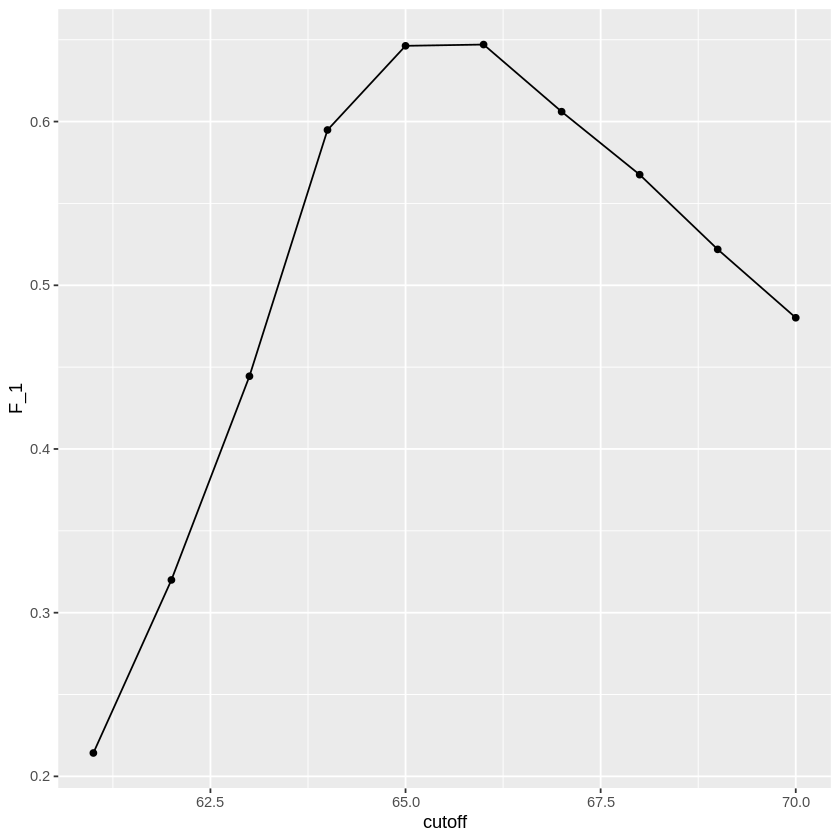

In [30]:
data.frame(cutoff, F_1) %>% 
  ggplot(aes(cutoff, F_1)) + 
  geom_point() + 
  geom_line()

In [31]:
max(F_1)

[1] 0.6470588

In [32]:
best_cutoff_2 <- cutoff[which.max(F_1)]
best_cutoff_2

[1] 66

In [33]:
y_hat <- ifelse(test_set$height > best_cutoff_2, "Male", "Female") %>% 
  factor(levels = levels(test_set$sex))
sensitivity(data = y_hat, reference = test_set$sex)
specificity(data = y_hat, reference = test_set$sex)

[1] 0.6302521

[1] 0.8325123

## ROC and precision-recall curves\

ROC=REciever Operating Characteristic curve-graphs multiple methods and compares them

Weakness-neither of the measures plotted depend on prevalance

Precision recall plot-plots precision and recall

In [34]:
p <- 0.9
n <- length(test_index)
y_hat <- sample(c("Male", "Female"), n, replace = TRUE, prob=c(p, 1-p)) %>% 
  factor(levels = levels(test_set$sex))
mean(y_hat == test_set$sex)

[1] 0.6838095

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


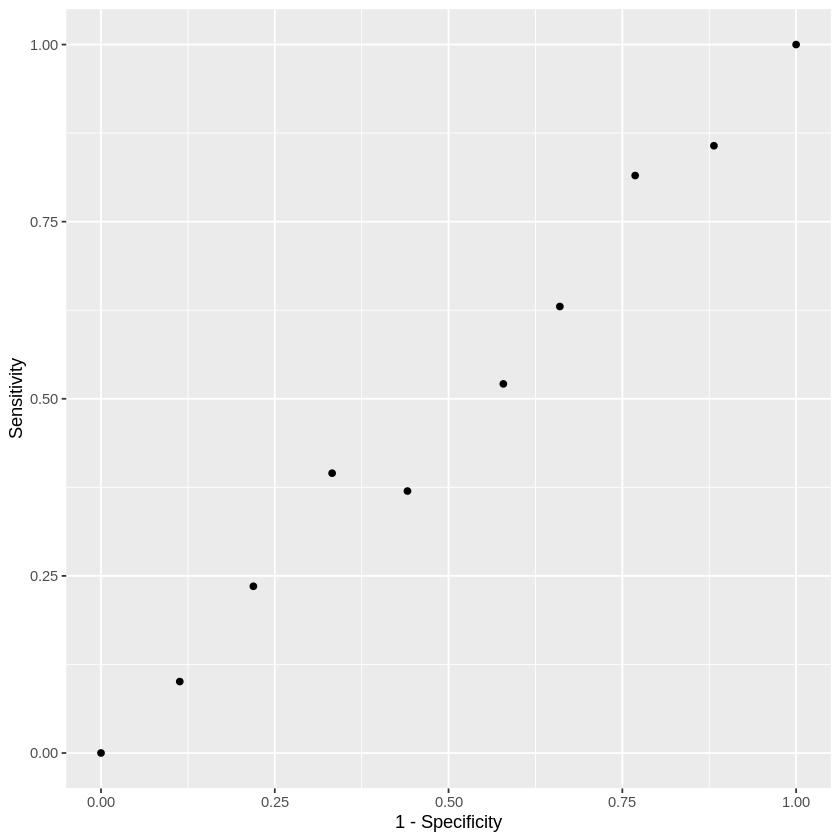

In [35]:
# ROC curve
probs <- seq(0, 1, length.out = 10)
guessing <- map_df(probs, function(p){
  y_hat <- 
    sample(c("Male", "Female"), n, replace = TRUE, prob=c(p, 1-p)) %>% 
    factor(levels = c("Female", "Male"))
  list(method = "Guessing",
       FPR = 1 - specificity(y_hat, test_set$sex),
       TPR = sensitivity(y_hat, test_set$sex))
})
guessing %>% qplot(FPR, TPR, data =., xlab = "1 - Specificity", ylab = "Sensitivity")

In [36]:
cutoffs <- c(50, seq(60, 75), 80)
height_cutoff <- map_df(cutoffs, function(x){
  y_hat <- ifelse(test_set$height > x, "Male", "Female") %>% 
    factor(levels = c("Female", "Male"))
   list(method = "Height cutoff",
        FPR = 1-specificity(y_hat, test_set$sex),
        TPR = sensitivity(y_hat, test_set$sex))
})

Installing package into ‘/home/jesuspacheco69jp/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



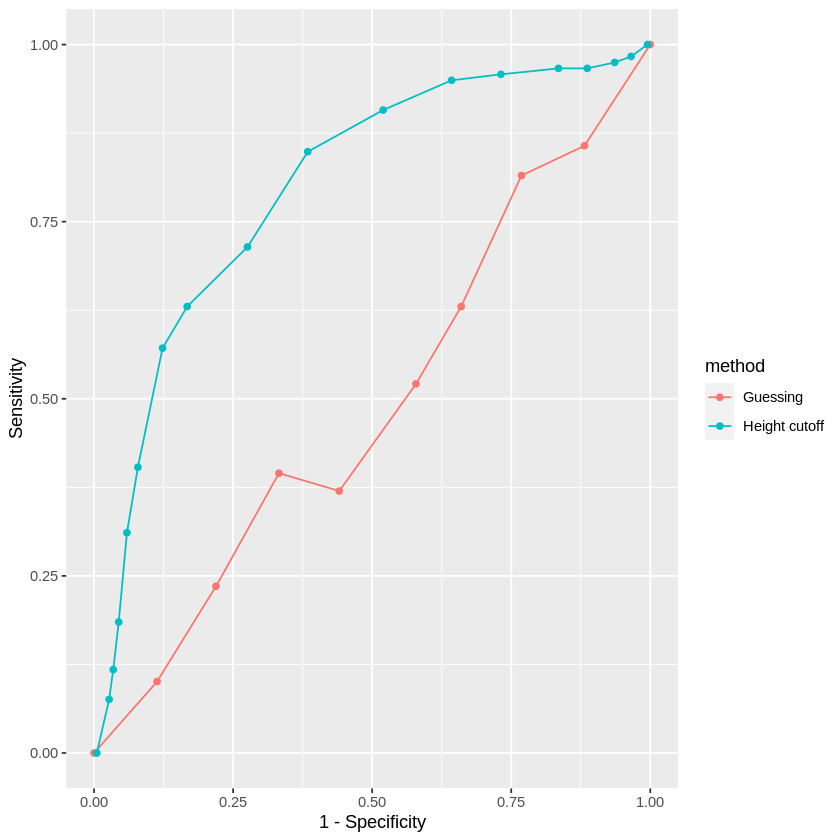

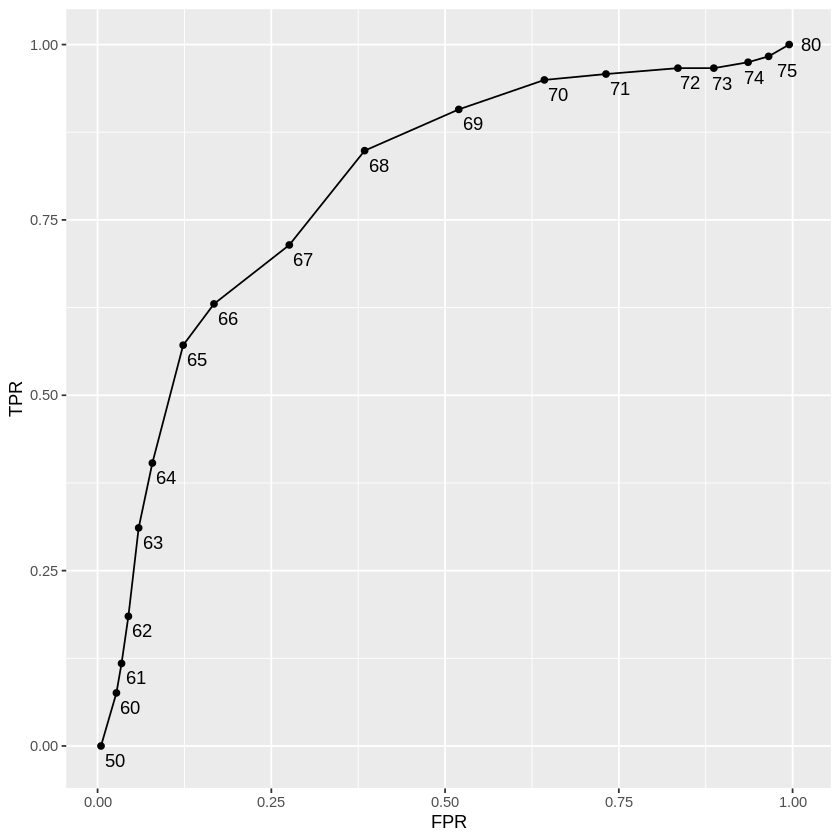

In [38]:
# plot both curves together
install.packages("ggrepel")
bind_rows(guessing, height_cutoff) %>%
  ggplot(aes(FPR, TPR, color = method)) +
  geom_line() +
  geom_point() +
  xlab("1 - Specificity") +
  ylab("Sensitivity")

library(ggrepel)
map_df(cutoffs, function(x){
  y_hat <- ifelse(test_set$height > x, "Male", "Female") %>% 
    factor(levels = c("Female", "Male"))
   list(method = "Height cutoff",
        cutoff = x, 
        FPR = 1-specificity(y_hat, test_set$sex),
        TPR = sensitivity(y_hat, test_set$sex))
}) %>%
  ggplot(aes(FPR, TPR, label = cutoff)) +
  geom_line() +
  geom_point() +
  geom_text_repel(nudge_x = 0.01, nudge_y = -0.01)

In [39]:
# plot precision against recall
guessing <- map_df(probs, function(p){
  y_hat <- sample(c("Male", "Female"), length(test_index), 
                  replace = TRUE, prob=c(p, 1-p)) %>% 
    factor(levels = c("Female", "Male"))
  list(method = "Guess",
    recall = sensitivity(y_hat, test_set$sex),
    precision = precision(y_hat, test_set$sex))
})

In [40]:
height_cutoff <- map_df(cutoffs, function(x){
  y_hat <- ifelse(test_set$height > x, "Male", "Female") %>% 
    factor(levels = c("Female", "Male"))
  list(method = "Height cutoff",
       recall = sensitivity(y_hat, test_set$sex),
    precision = precision(y_hat, test_set$sex))
})

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


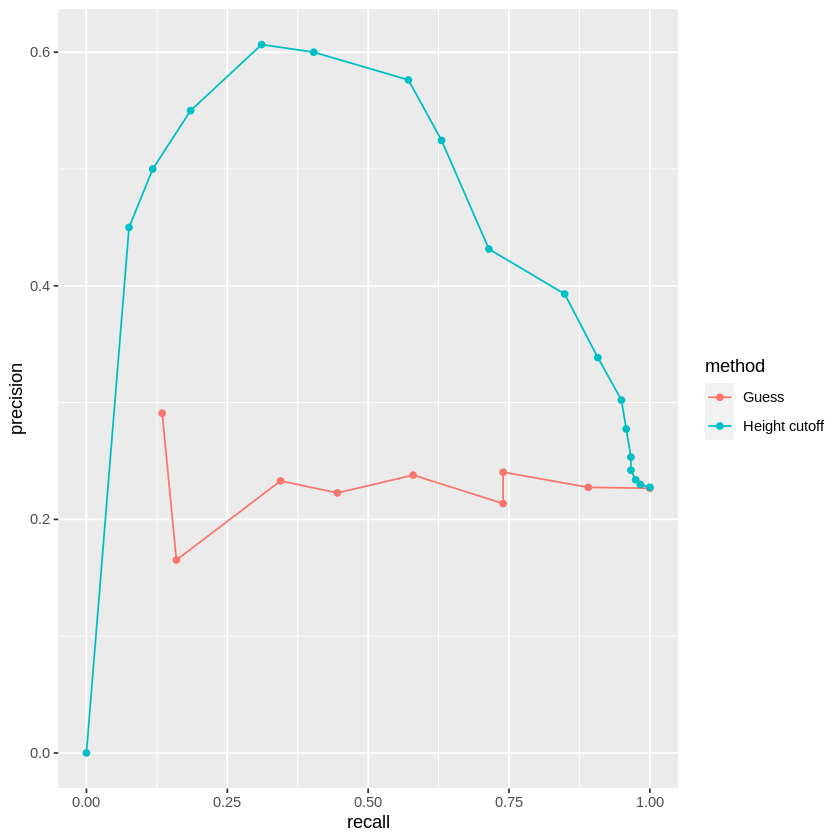

In [41]:
bind_rows(guessing, height_cutoff) %>%
  ggplot(aes(recall, precision, color = method)) +
  geom_line() +
  geom_point()
guessing <- map_df(probs, function(p){
  y_hat <- sample(c("Male", "Female"), length(test_index), replace = TRUE, 
                  prob=c(p, 1-p)) %>% 
    factor(levels = c("Male", "Female"))
  list(method = "Guess",
    recall = sensitivity(y_hat, relevel(test_set$sex, "Male", "Female")),
    precision = precision(y_hat, relevel(test_set$sex, "Male", "Female")))
})

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


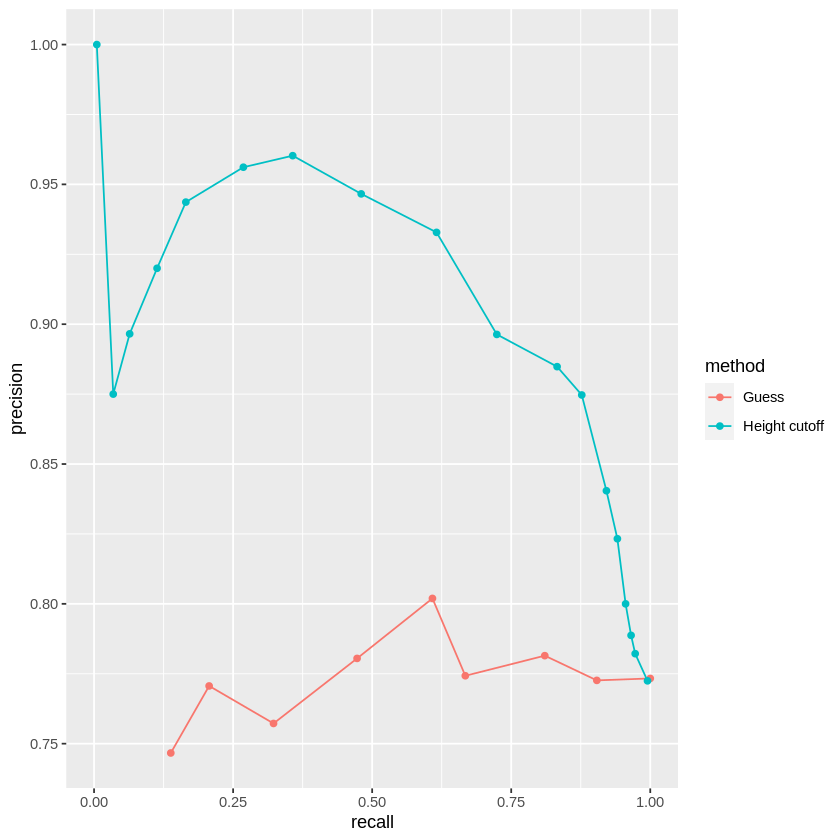

In [42]:
height_cutoff <- map_df(cutoffs, function(x){
  y_hat <- ifelse(test_set$height > x, "Male", "Female") %>% 
    factor(levels = c("Male", "Female"))
  list(method = "Height cutoff",
       recall = sensitivity(y_hat, relevel(test_set$sex, "Male", "Female")),
    precision = precision(y_hat, relevel(test_set$sex, "Male", "Female")))
})
bind_rows(guessing, height_cutoff) %>%
  ggplot(aes(recall, precision, color = method)) +
  geom_line() +
  geom_point()

## Loss function

Most coomon is squared loss function

for test sets with many observation use mean squared error

# Other loss functions

root mean squared error

if outcomes are binary RMSE and MSE are equall to 1 - accuraccy

goal of algorithm is to make loss as close to 0

# Condtional Probalbilities

most datasets will include groups of observations with the same exact observed values for all predictors but with diffrent outcomes

Bayes Rule-mathmatical formula for finding out the likelyhood of something happening

# Exceptations

the same observed predictors do not gurantee the same continous outcomes,assume taht outcomes follow the same conditional distribution

## Linear Regression

Digits case study-2 predictors and two 2 classes
break digits in 4 squares
linear regression == p(x1,x2)=pr(Y=1|X1=x1,X2=x2)=B0+B1X1+B2+X2
boundary=p(x,y)=0.5=boundary has to be straight line
regression approach has no chance of capturing the non-linear natureof the true p(x1,x2)
if pattern is felxable or non linear then linear regresion wont work

In [1]:
library(tidyverse)
library(dslabs)
data("mnist_27")


In [10]:
str(mnist_27)

List of 5
 $ train      :'data.frame':	800 obs. of  3 variables:
  ..$ y  : Factor w/ 2 levels "2","7": 1 2 1 1 2 1 2 2 2 1 ...
  ..$ x_1: num [1:800] 0.0395 0.1607 0.0213 0.1358 0.3902 ...
  ..$ x_2: num [1:800] 0.1842 0.0893 0.2766 0.2222 0.3659 ...
 $ test       :'data.frame':	200 obs. of  3 variables:
  ..$ y  : Factor w/ 2 levels "2","7": 1 2 2 2 2 1 1 1 1 2 ...
  ..$ x_1: num [1:200] 0.148 0.283 0.29 0.195 0.218 ...
  ..$ x_2: num [1:200] 0.261 0.348 0.435 0.115 0.397 ...
 $ index_train: int [1:800] 40334 33996 3200 38360 36239 38816 8085 9098 15470 5096 ...
 $ index_test : int [1:200] 46218 35939 23443 30466 2677 54248 5909 13402 11031 47308 ...
 $ true_p     :'data.frame':	22500 obs. of  3 variables:
  ..$ x_1: num [1:22500] 0 0.00352 0.00703 0.01055 0.01406 ...
  ..$ x_2: num [1:22500] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ p  : num [1:22500] 0.703 0.711 0.719 0.727 0.734 ...
  ..- attr(*, "out.attrs")=List of 2
  .. ..$ dim     : Named int [1:2] 150 150
  .. .. ..- attr(*, "names")= c

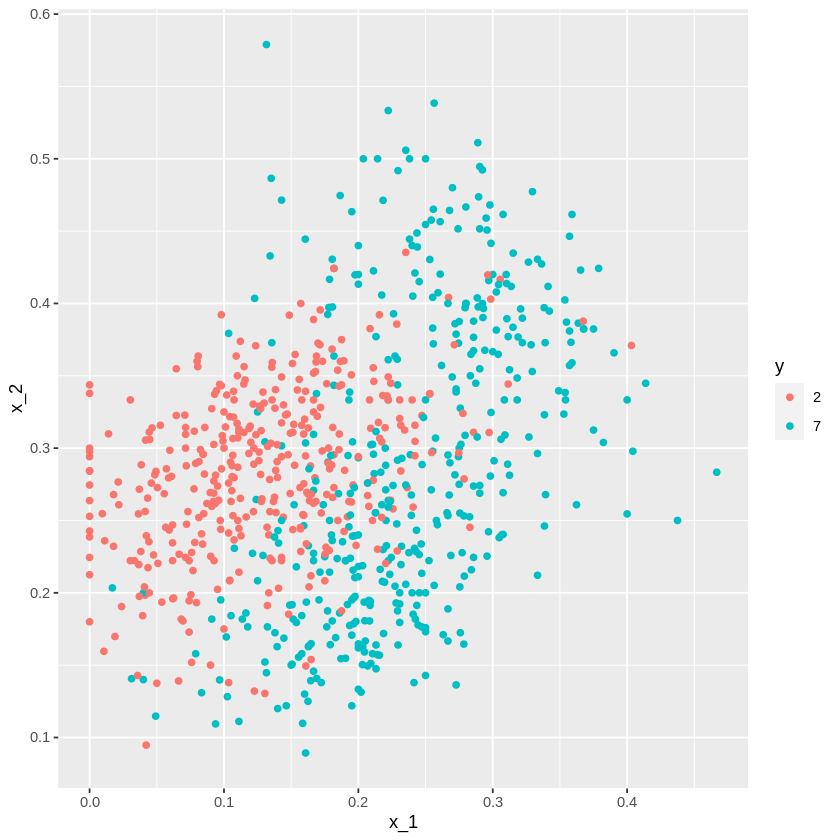

In [9]:
# explore the data by plotting the two predictors
mnist_27$train %>% ggplot(aes(x_1, x_2, color = y)) + geom_point()

In [12]:
fit <- mnist_27$train %>%
  mutate(y = ifelse(y == 7, 1, 0))%>%
  lm(y ~ x_1 + x_2, data = .)

In [13]:
p_hat <- predict(fit, newdata = mnist_27$test, type = "response")

In [14]:
library(caret)
p_hat <- predict(fit, newdata = mnist_27$test)
y_hat <- factor(ifelse(p_hat > 0.5, 7, 2))
confusionMatrix(y_hat, mnist_27$test$y)$overall[["Accuracy"]]

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




[1] 0.75

## Smoothing

made to detect trends in louisy data

conditonal expectations can be thoiught of as trends of unknown shapes that we need to estimate in the presense of uncertainty

f(x)-error to the uncertainty of trends

Bin Smoothing and kernals-weighted average

f(x) is constant in small periods of time

Bin smoothing-make this calculation with each value of x as the average

box kernal-produces function that looks like a box

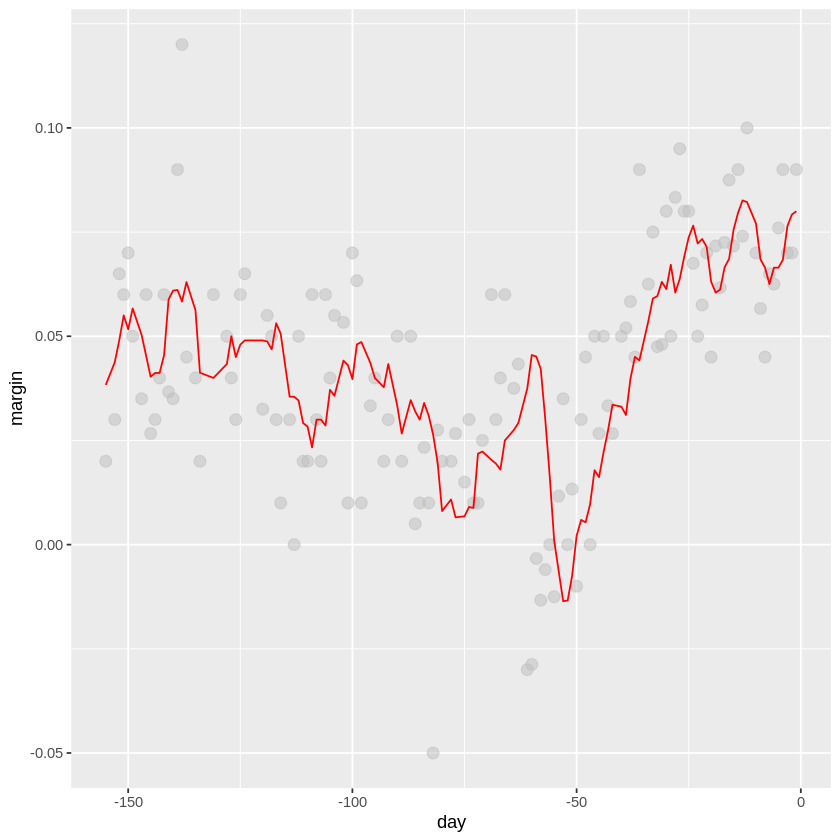

In [22]:
# larger span
span <- 7 
fit <- with(polls_2008, 
            ksmooth(day, margin, kernel = "box", bandwidth = span))

polls_2008 %>% mutate(smooth = fit$y) %>%
  ggplot(aes(day, margin)) +
    geom_point(size = 3, alpha = .5, color = "grey") + 
  geom_line(aes(day, smooth), color="red")

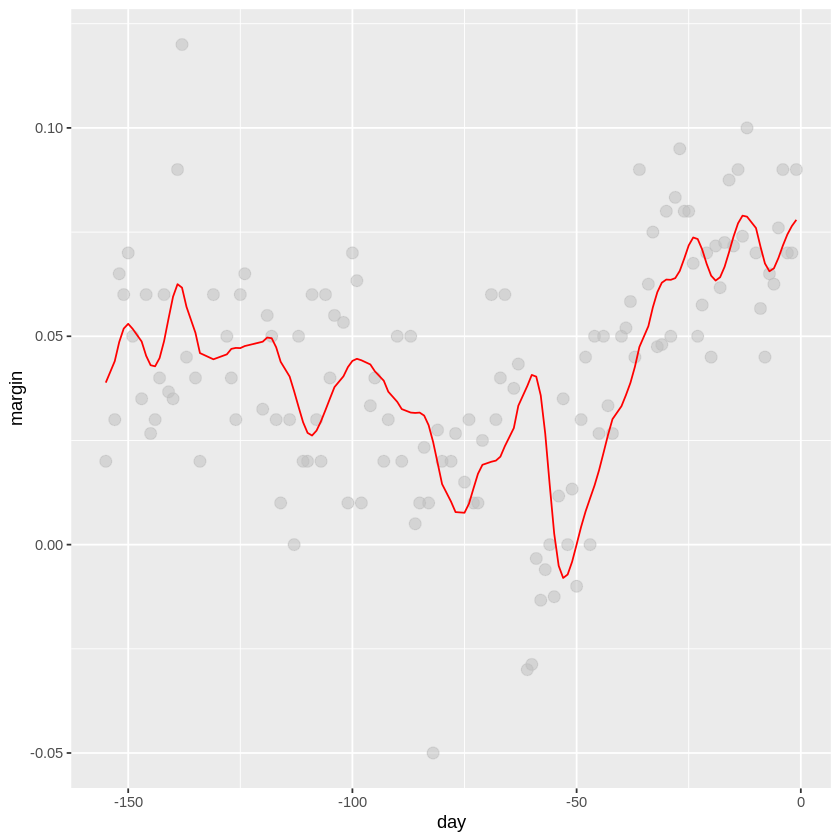

In [23]:
span <- 7
fit <- with(polls_2008, 
            ksmooth(day, margin, kernel = "normal", bandwidth = span))

polls_2008 %>% mutate(smooth = fit$y) %>%
  ggplot(aes(day, margin)) +
  geom_point(size = 3, alpha = .5, color = "grey") + 
  geom_line(aes(day, smooth), color="red")

## loess

local weighted regression-made for larger spans of data

Taylor Theoream-all functions will contain straight lines-functions are locally linear. Functions made up of smaller lines no matter the shape of the complete line

Function=E[Yi|Xi=xi]


`geom_smooth()` using formula = 'y ~ x'


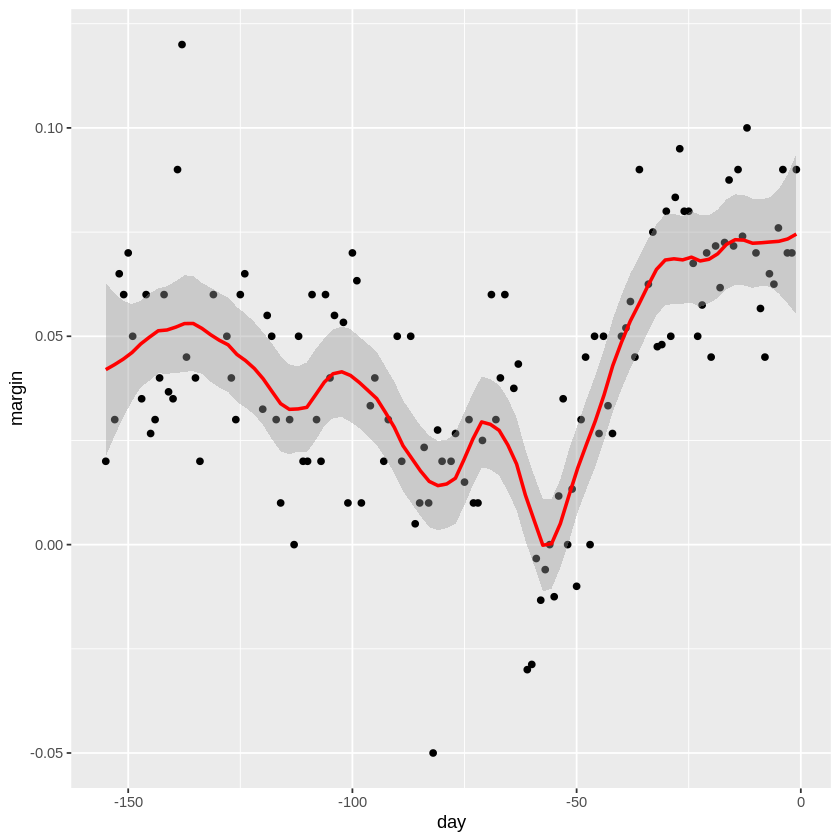

In [24]:
polls_2008 %>% ggplot(aes(day, margin)) +
  geom_point() +
  geom_smooth(color="red", span = 0.15, method = "loess", method.args = list(degree=1))

## Default smoothing parameters

Can make our windows even larger and fit parabolas instead of lines

Not optimal but can be easily changed

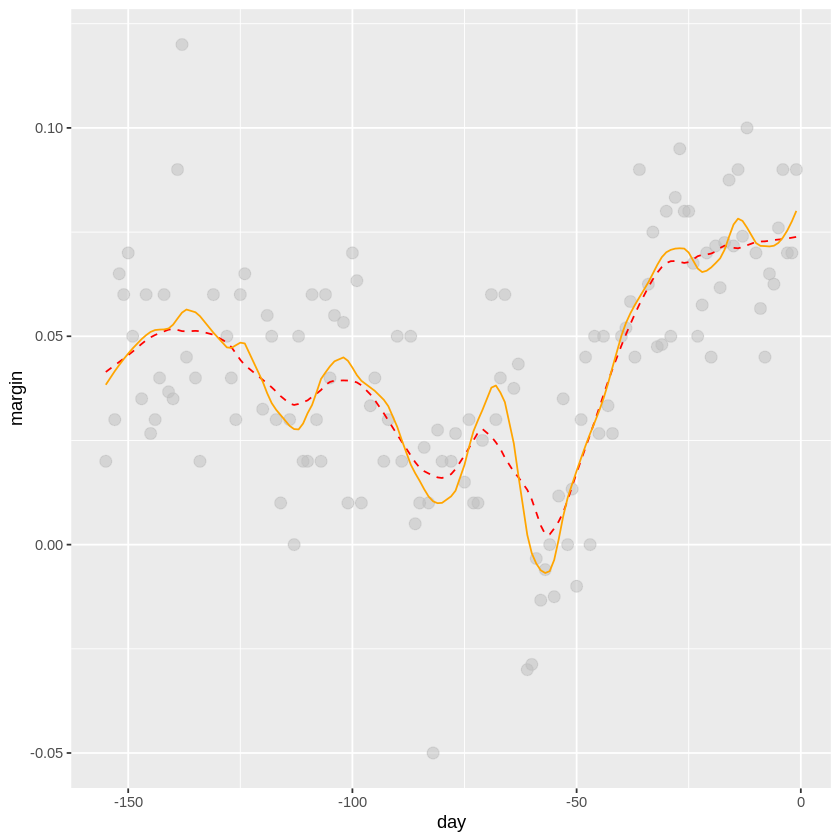

In [26]:
total_days <- diff(range(polls_2008$day))
span <- 28/total_days
fit_1 <- loess(margin ~ day, degree=1, span = span, data=polls_2008)
fit_2 <- loess(margin ~ day, span = span, data=polls_2008)


polls_2008 %>% mutate(smooth_1 = fit_1$fitted, smooth_2 = fit_2$fitted) %>%
     ggplot(aes(day, margin)) +
     geom_point(size = 3, alpha = .5, color = "grey") +
     geom_line(aes(day, smooth_1), color="red", lty = 2) +
     geom_line(aes(day, smooth_2), color="orange", lty = 1)

## Connecting Smoothing to Machine Learning

linear regression not flexable enough to capture non-linear nature of p(x1,x2)

## ks Nearest Neighbor

cross validation

First-define distance between all observations based on the features

neighborhood-data used to define distance

larger ks result in smoother estimates. Smaller ks result in more flexiable and wiggly estimates

knn3()-specify formula(predictor1+p2+p3) and a data frame

predict()-Produces a probabilty

overTraining-results in Higher accuracy in traing sets than than that in test sets

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


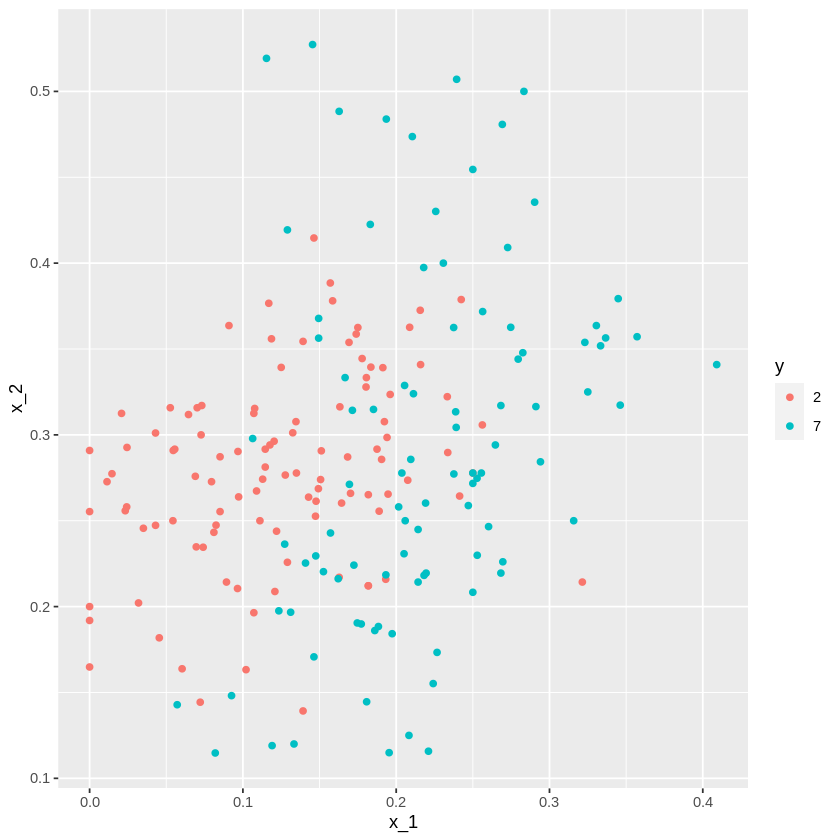

In [1]:
library(tidyverse)
library(dslabs)
data("mnist_27")
mnist_27$test %>%
  ggplot(aes(x_1, x_2, color = y)) +
  geom_point()


In [2]:
library(caret)
knn_fit <- knn3(y ~ ., data = mnist_27$train)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [3]:
y_hat_knn <- predict(knn_fit, mnist_27$test, type = "class")

In [4]:
confusionMatrix(y_hat_knn, mnist_27$test$y)$overall["Accuracy"]

Accuracy 
   0.815

Overtraining at its worst when we set k=1

if answers are not unique then data will not be allowed flexability

over-Smoothing

crossvalidation helps avoid over training

In [5]:
knn_fit_1 <- knn3(y ~ ., data = mnist_27$train, k = 1)
y_hat_knn_1 <- predict(knn_fit_1, mnist_27$train, type = "class")
confusionMatrix(y_hat_knn_1, mnist_27$train$y)$overall["Accuracy"]

Accuracy 
       1

In [6]:
y_hat_knn_1 <- predict(knn_fit_1, mnist_27$test, type = "class")
confusionMatrix(y_hat_knn_1, mnist_27$test$y)$overall["Accuracy"]

Accuracy 
   0.735

## choosing k

map_df()-apply same model for each k

graph is jagged because data use random variables

golden rule of machine learning:The test data cannot influence training the model in any way


In [7]:
ks <- seq(3, 251, 2)

In [8]:
library(purrr)
accuracy <- map_df(ks, function(k){
  fit <- knn3(y ~ ., data = mnist_27$train, k = k)
  
  y_hat <- predict(fit, mnist_27$train, type = "class")
  cm_train <- confusionMatrix(y_hat, mnist_27$train$y)
  train_error <- cm_train$overall["Accuracy"]
  
  y_hat <- predict(fit, mnist_27$test, type = "class")
  cm_test <- confusionMatrix(y_hat, mnist_27$test$y)
  test_error <- cm_test$overall["Accuracy"]
  
  tibble(train = train_error, test = test_error)
})

In [9]:
ks[which.max(accuracy$test)]

[1] 41

In [10]:
max(accuracy$test)

[1] 0.86

## Mathematical description of cross-validation

Goal of machine learning:mimumize MSE(Mean Squared Error)

Two types of mse:Theoretical(true) and observed(apparent)

apparent error:data we use is a random so variable is also random and if we train an algorithm on the same dataset we use to compute the apparent error,we might be over training

true error-average of how many apparent errors obtained by applying the algorithm to new random samples of data

cross validation-helps relive problems obtained by apparent errors

Cross-validation helps imitate the theoretical set up of the true error as best as possible using the data we have. To do this, cross-validation randomly generates smaller datasets that are used to estimate the true error.

## k-fold cross-validation

in cross validation use 10-20 percent of data for testing

parameters will be the same through all training sets

find parameter that provides smallest MSE

better to use many folds as it better estimates the orignal dataset but will make runtime slower

k=5 or 10 are very popular

to better calculate mse we create more non-overlapping data sets.

## Caret Package

237 diffrent methods

provides methpd used in cross validation

can create training data with train()-cross valid

can create predictions with predict()

can eaily plot with ggplot

hightlight()-highlights max

We can use the tunegrid() parameter in the train() function to select a grid of values to be compared.

The trControl parameter and trainControl() function can be used to change the way cross-validation is performed.

Note that not all parameters in machine learning algorithms are tuned. We use the train() function to only optimize parameters that are tunable.

In [1]:
library(tidyverse)
library(dslabs)
data("mnist_27")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(caret)
train_glm <- train(y ~ ., method = "glm", data = mnist_27$train)
train_knn <- train(y ~ ., method = "knn", data = mnist_27$train)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [3]:
y_hat_glm <- predict(train_glm, mnist_27$test, type = "raw")
y_hat_knn <- predict(train_knn, mnist_27$test, type = "raw")

In [4]:
confusionMatrix(y_hat_glm, mnist_27$test$y)$overall[["Accuracy"]]
confusionMatrix(y_hat_knn, mnist_27$test$y)$overall[["Accuracy"]]

[1] 0.75

[1] 0.84

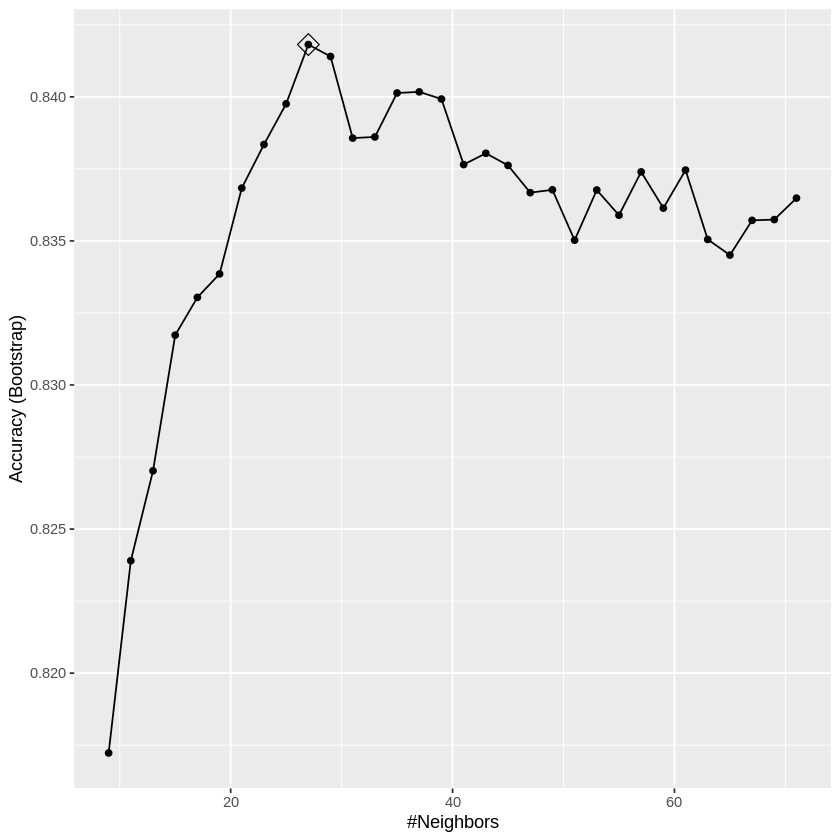

In [5]:
set.seed(2008)
train_knn <- train(y ~ ., method = "knn",
                   data = mnist_27$train,
                   tuneGrid = data.frame(k = seq(9, 71, 2)))

ggplot(train_knn, highlight = TRUE)

In [8]:
train_knn$bestTune
train_knn$finalModel

,k
,<dbl>
10,27


27-nearest neighbor model
Training set outcome distribution:

  2   7 
379 421 


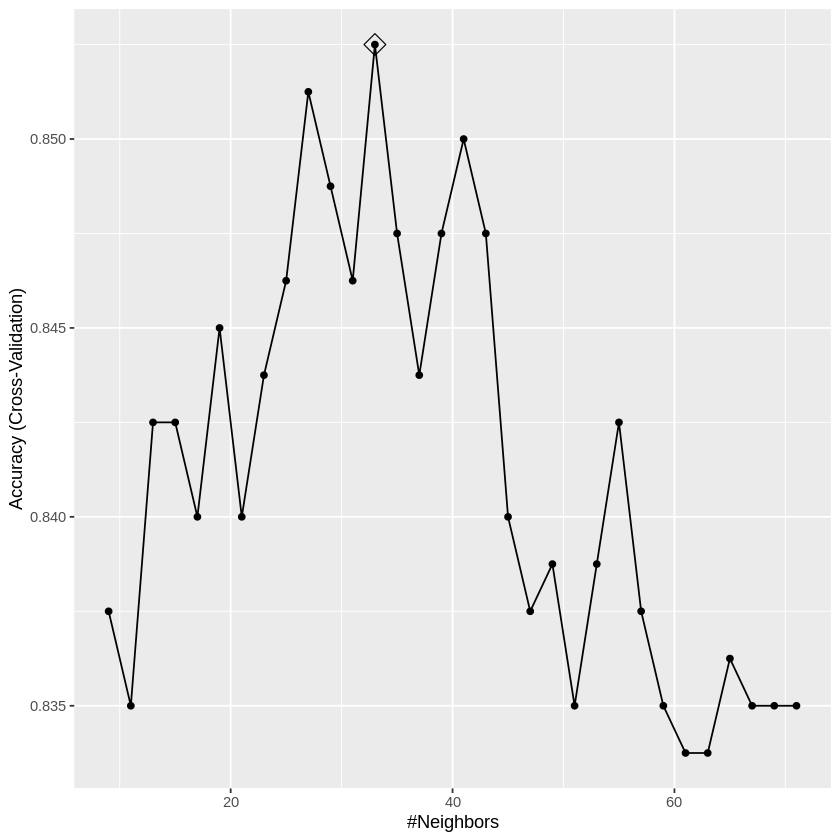

In [10]:
control <- trainControl(method = "cv", number = 10, p = .9)
train_knn_cv <- train(y ~ ., method = "knn",
                      data = mnist_27$train,
                      tuneGrid = data.frame(k = seq(9, 71, 2)),
                      trControl = control)
ggplot(train_knn_cv, highlight = TRUE)

## Fitting w/ Loess

gamloess-install gam package-allows us to fit a model using the gamLoess method in caret. This method produces a smoother estimate of the conditional probability than kNN.

Installing package into ‘/home/jesuspacheco69jp/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,gamLoess,span,Span,TRUE,TRUE,TRUE
2,gamLoess,degree,Degree,TRUE,TRUE,TRUE


Loading required package: gam

Loading required package: splines

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loaded gam 1.22-2


Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.2055555555

Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.427777777777778, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.427777777777778, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.427777777777778, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.483333333333333, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.483333333333333, degree = 1)"]], :
“upperlimit  0.54

Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“lowerlimit  0.092518”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.54068”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“lowerlimit  0.092518”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], 

Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.094737”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“extrapolation no

Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.094737”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degr

Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“extrapolation not 

Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“upperlimit  0.54068”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“lowerlimit  0.092518”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“upperlimit  0.54068”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“eval  0.

Warning message in gam.lo(data[["lo(x_1, span = 0.205555555555556, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“lowerlimit  0.092518”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“upperlimit  0.54068”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.261111111111111, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.261111111111111, degree = 1)"]], :
“upperlimit  0.

Warning message in gam.lo(data[["lo(x_1, span = 0.483333333333333, degree = 1)"]], :
“upperlimit  0.40628”
Warning message in gam.lo(data[["lo(x_1, span = 0.483333333333333, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“lowerlimit  0.092518”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“upperlimit  0.54068”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“eval  0.

Warning message in gam.lo(data[["lo(x_1, span = 0.372222222222222, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.427777777777778, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.427777777777778, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.427777777777778, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.427777777777778, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.427777777777778, degree = 1)"]], :
“upperlimit  0.54

Warning message in gam.lo(data[["lo(x_2, span = 0.483333333333333, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.483333333333333, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.483333333333333, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“upperlimit  0.54071”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blend

Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“upperlimit  0.41586”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.41586”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.4375”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.41586”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree 

Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“eval  0.4375”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“upperlimit  0.41586”
Warning message in gam.lo(data[["lo(x_1, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“upperlimit  0.4

Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation no

Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.205555555555556, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“lowerlimit  0.092316”
Warning message in gam.lo(data[["lo(x_2, span = 0.261111111111111, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"

Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“upperlimit  0.53553”
Warning message in gam.lo(data[["lo(x_2, span = 0.316666666666667, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.372222222222222, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.372222222222222, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.372222222222222, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.372222222222222, degree = 1)"]], :
“lowerlimit  0.0

Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.53553”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, w, span = 0.15, :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.15, degree = 1)"]], z, 

Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.538888888888889, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“eval  0.46667”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“upperlimit  0.43969”
Warning message in gam.lo(data[["lo(x_1, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“eval  0.089286”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“lowerlimit  0.10703”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“eval  0.0

Warning message in gam.lo(data[["lo(x_2, span = 0.594444444444444, degree = 1)"]], :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.53846”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.53555”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“eval  0.57895”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“upperlimit  0.53555”
Warning message in gam.lo(data[["lo(x_2, span = 0.65, degree = 1)"]], z, w, span = 0.65, :
“extrapolation not allowed with blending”


Accuracy 
    0.85

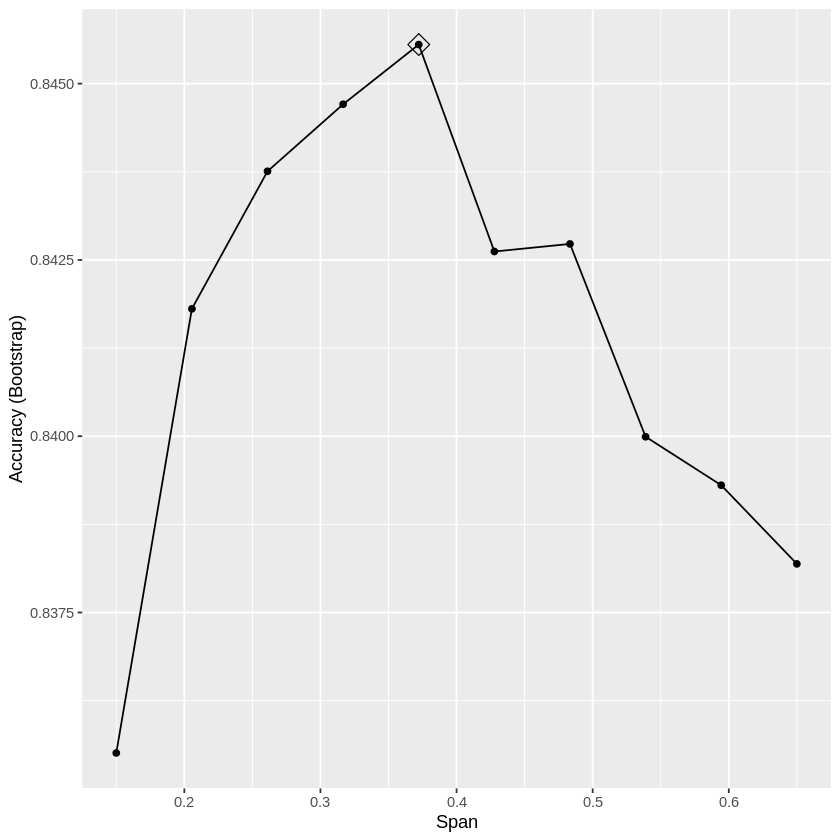

In [11]:
install.packages("gam")
modelLookup("gamLoess")

grid <- expand.grid(span = seq(0.15, 0.65, len = 10), degree = 1)

train_loess <- train(y ~ ., 
               method = "gamLoess",
               tuneGrid=grid,
               data = mnist_27$train)
ggplot(train_loess, highlight = TRUE)

confusionMatrix(data = predict(train_loess, mnist_27$test), 
                reference = mnist_27$test$y)$overall["Accuracy"]

## Trees and Random Forest

LDA and QDA are not meant to be used with many preditors

Curse of dimensionality-neighborhoods can become to large or not flexiable enough

tree-flow chart of yes or no questions

regression tree-when outcomne is countinous

classification-when outcome is categorial

Descision trees operate by predicting an outcome by partioning the predictors

two common parameters are complexity parameter and minimum number of observations required in a partition

Classification trees form predictions by calculating which class is the most common

Random forests-The goal is to improve prediction performance and reduce instability by averaging multiple decision trees

A disadvantage of random forests is that we lose interpretability.

An approach that helps with interpretability is to examine variable importance.\

To define variable importance we count how often a predictor is used in the individual trees.

preprosseing examples-changeing predictors,standardizing the predictors,taking logtransform of predictors,removing predictors that are highlhy correclated or have very few non unique values

nearzero()-finds values close to zero,helps remove invaluable data and makes algorithm run faster

k fold cross validation-helps run speed 

random forest-slow,uses 5 folds,better for large data sets,black box model(cant write formulas to predict)

varibale importane-tells you what values are most used 

ensembles-mixing multiple algorithms into one.

p_rf <- predict(fit_rf, x_test[,col_index], type = "prob")
p_rf <- p_rf / rowSums(p_rf)
p_knn <- predict(fit_knn, x_test[,col_index])
p <- (p_rf + p_knn)/2
y_pred <- factor(apply(p, 1, which.max)-1)
confusionMatrix(y_pred, y_test)$overall["Accuracy"]